# Brain Signal Analysis for Classifying Eye Movement Events

A total of 80 CSV files were gathered. Each file contained two columns: amplitudes and time, and the names were formatted like“0525Left01” to indicate the date recorded and the type of eye movement.  The data contained a total count of 1,640 events, and the events are based on the type of eye movement event.

- Blink:
    * Single: 800 seconds of 177 events
    * Double: 120 seconds of 18 events
- Left Movement:
    * Single: 200 seconds of 38 events
    * Double: 80 seconds of 13 events
- Right Movement:
    * Single: 200 seconds of 42 events
    * Double: 80 seconds of 14 events
- Mixed Events: 100 seconds of 16 events
- No Events: 60 seconds

In [1]:
from pathlib import Path

data_dir = Path("data")

def filter_path(path):
    return (path.parent.stem != ".ipynb_checkpoints"
        and "week7" not in str(path)
        and "week8" not in str(path))

data_paths = sorted(filter(filter_path, data_dir.glob("**/*.csv")))
data_paths

[PosixPath('data/week10/1005BLINKS1.csv'),
 PosixPath('data/week10/1005BLINKS10.csv'),
 PosixPath('data/week10/1005BLINKS11.csv'),
 PosixPath('data/week10/1005BLINKS12.csv'),
 PosixPath('data/week10/1005BLINKS13.csv'),
 PosixPath('data/week10/1005BLINKS14.csv'),
 PosixPath('data/week10/1005BLINKS15.csv'),
 PosixPath('data/week10/1005BLINKS16.csv'),
 PosixPath('data/week10/1005BLINKS17.csv'),
 PosixPath('data/week10/1005BLINKS2.csv'),
 PosixPath('data/week10/1005BLINKS3.csv'),
 PosixPath('data/week10/1005BLINKS4.csv'),
 PosixPath('data/week10/1005BLINKS5.csv'),
 PosixPath('data/week10/1005BLINKS6.csv'),
 PosixPath('data/week10/1005BLINKS7.csv'),
 PosixPath('data/week10/1005BLINKS8.csv'),
 PosixPath('data/week10/1005BLINKS9.csv'),
 PosixPath('data/week11/0510DOUBLEBLINK01.csv'),
 PosixPath('data/week11/0510LEFT01.csv'),
 PosixPath('data/week11/0510LEFT02.csv'),
 PosixPath('data/week11/0510LEFT03.csv'),
 PosixPath('data/week11/0510RIGHT01.csv'),
 PosixPath('data/week11/0510RIGHT02.csv'),


### Data loading

The volume of data was sufficient for further data analysis, with some limitations. Firstly, the CSV file was used instead of a WAV file, which caused large amounts of storage space to be used as the CSV files occupied almost twenty times more storage than equivalent WAV files. Besides, the data collected during the first two weeks did not record which eye the electrodes were attached close to. This led to confusion in classifying the left and right movements. However, this problem was noticed in the third week of the project and was thus prevented by using the user's right eye for further data collection.

In [2]:
import numpy as np

def load_data(path, with_laps="laps.txt", reverse=True):
    laps = []
    if with_laps:
        name = path.stem
        found = False
        laps_txt = path.parent / with_laps
        if laps_txt.exists():
            with open(laps_txt) as f:
                for line in f.readlines():
                    line = line.strip()
                    if not line:
                        pass
                    elif not line.replace(".", "").isnumeric():
                        if found:
                            break
                        if name == line:
                            found = True
                    elif found:
                        laps.append(float(line))
                laps = np.cumsum(np.array(laps))
    arr = np.genfromtxt(path, delimiter=",")
    time, amp = arr.T
    if time[-1] < time[0]:
        time = np.max(time) - time
        amp = amp[::-1]

    return time, amp, laps if len(laps) else None

### Graphical representation of data

Graphical representation helps us understand the nature of the data and build a responsive event detector. We plotted the amplitude of the EOG signal data with the prediction extrapolated to the range of the signal data so we could visually check if the prediction was valid. We expect the prediction to be high when the signal shows a dispersion (high peaks and low valleys). From those plots, we could also examine the latency by looking at when the EOG signal becomes stable and when the signal falls back to low. Attempts were made to record timestamped data but the qualitative latency metrics derived from that were unreliable (more about this in Discussion).


In [3]:
import matplotlib.pyplot as plt

def plot_data(time, amp, laps=None, /, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(time, amp)
    if laps is not None:
        ax.vlines(laps, np.min(amp), np.max(amp),
                  color="red")

In [4]:
from tqdm.auto import tqdm

figure_dir = Path("figure/raw")

for path in tqdm(data_paths):
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    if where.exists():
        continue

    fig, ax = plt.subplots(figsize=(12, 4))
    time, amp, laps = load_data(path)
    plot_data(time, amp, laps)
    ax.set_title(path.stem)
    where.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(where)
    plt.close()

  0%|          | 0/59 [00:00<?, ?it/s]

### Seed

Set seed for reproducibility.

In [5]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

## Event Detection

This model uses a variance-based classifier to detect whether an event occurs during a defined time interval (window). The variance of the window represents the difference between the amplitude within the window and the total average amplitude. If there is high variance of the window, it will illustrate the high possibility of sudden changes in amplitude. Therefore, this event classifier is defined as if the variance of the window exceeds the set threshold, then an event occurs in this window.


### Moving Average of Absolute Difference

In [6]:
from scipy.signal import find_peaks

figure_dir = Path("figure/prominence_50/")

for path in tqdm(data_paths):
    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    
    time, amp, laps = load_data(path)
    
    amp_mean = np.mean(amp)
    abs_diff = np.r_[0, np.abs(np.diff(amp))]
    moving_avg = np.convolve(abs_diff, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    high_peaks, _ = find_peaks(amp - amp_mean, prominence=50)
    low_peaks, _ = find_peaks(amp_mean - amp, prominence=50)
    
    fig = plt.figure(figsize=(12, 4))
    plot_data(time, amp)
    plot_data(time, np.where(moving_avg > 0.02, max(amp), min(amp)))
    plt.scatter(time[high_peaks], amp[high_peaks], c="green", marker="x")
    plt.scatter(time[low_peaks], amp[low_peaks], c="red", marker="x")
    
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)    
    fig.savefig(where)
    plt.close()

  0%|          | 0/59 [00:00<?, ?it/s]

### Variance

In [7]:
from scipy.signal import find_peaks

figure_dir = Path("figure/prominence_90/")

for path in tqdm(data_paths):
    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    
    time, amp, laps = load_data(path)
    
    amp_med = np.median(amp)
    error = amp - amp_med
    std = np.convolve(error ** 2, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    high_peaks, _ = find_peaks(amp - amp_mean, prominence=90)
    low_peaks, _ = find_peaks(amp_mean - amp, prominence=90)
    
    fig = plt.figure(figsize=(12, 4))
    plot_data(time, amp)
    plot_data(time, np.where(std > 150, max(amp), min(amp)))
    plt.scatter(time[high_peaks], amp[high_peaks], c="green", marker="x")
    plt.scatter(time[low_peaks], amp[low_peaks], c="red", marker="x")
    
    where = figure_dir / path.relative_to(data_dir).with_suffix(".png")
    where.parent.mkdir(parents=True, exist_ok=True)    
    fig.savefig(where)
    plt.close()

  0%|          | 0/59 [00:00<?, ?it/s]

### Windowed Visualization

In [8]:
def sliding_window(time,
                   amp,
                   laps=None,
                   window_sec=1.0,
                   window_inc=0.2,
                   show_progress=True):
    n_window = int((max(time) - window_sec) // window_inc)
    iter_window = range(n_window)
    if show_progress:
        from tqdm.auto import tqdm
        iter_window = tqdm(iter_window, leave=False)
    for i in iter_window:
        start_sec = window_inc * i
        end_sec = start_sec + window_sec
        mask = (start_sec <= time) & (time < end_sec)
        if laps is not None:
            laps_masked = laps[(start_sec <= laps) & (laps < end_sec)]
            yield time[mask], amp[mask], laps_masked
        else:
            yield time[mask], amp[mask], None

# windows = sliding_window(time, amp, laps)
# for _ in range(25):
#     next(windows)
# window_time, window_amp, window_laps = next(windows)
# plt.figure(figsize=(12, 4))
# plot_data(window_time, window_amp, window_laps)
# plt.show()

In [9]:
def predict_event(time, amp,
                  event_classifier,
                  window_sec=1.2,
                  window_inc=0.05,
                  event_skip=None):
    if event_skip is None:
        event_skip = int(window_sec // window_inc)
    windows = sliding_window(time, amp)
    while (window := next(windows, None)) is not None:
        window_time, window_amp, _ = window
        has_event = event_classifier(window_amp)
        if has_event:
            yield min(window_time), max(window_time)
            for _ in range(event_skip):
                next(windows, None)

## Event Classficiation

### Slice

Most of our recorded data were 20- or 40-second labelled clips of repetitions of a single type of eye movement. Using our event detector, we can isolate events and use them as features for our event classification model. Our model takes in EOG signal clips of small but varying sizes and outputs its classification of the event (single/double and blink/left/right). The labelled clips allow us to derive qualitative metrics. To prevent overfitting, we used 5-fold cross-validation to acquire reliable accuracy scores. As mentioned in Data Processing, our dataset is not evenly distributed across the classes (types of eye movements), therefore, we used balanced accuracy scores weighted by the inverse of the number of samples in a class as reliable metrics.

In [10]:
import re
import pandas as pd
from tqdm.auto import tqdm

clip_df = []
for path in tqdm(data_paths):
    week = int(re.search(r"week(\d+)", str(path), flags=re.I).group(1))
    for s in ("left", "right", "blink", "no", "test"):
        if s in str(path).lower():
            label = s
            break
    else:
        raise ValueError()

    double = "double" in str(path)

    window_sec = 1.0
    window_n = int(10_000 * window_sec)
    minimum_sec = 0.2
    minimum_n = int(10_000 * minimum_sec)
    
    time, amp, laps = load_data(path)
    
    amp_med = np.median(amp)
    error = amp - amp_med
    std = np.convolve(error ** 2, np.ones(window_n), "full")[:-(window_n - 1)] / window_n
    event = (std > 150).astype(int)
    for i, j in np.where(np.diff(np.r_[0, event, 0]))[0].reshape(-1, 2):
        if j - i < minimum_n:
            continue
        clip_time = time[max(0, i - window_n):j]
        clip_amp = amp[max(0, i - window_n):j]
        clip_df.append({
            "week": week,
            "path": str(path),
            "label": label,
            "double": double,
            "time": clip_time,
            "amp": clip_amp,
        })

clip_df = pd.DataFrame(clip_df)

  0%|          | 0/59 [00:00<?, ?it/s]

In [11]:
clip_df.groupby(["label", "double"]).size()

label  double
blink  False     177
       True       18
left   False      38
       True       13
no     False       1
right  False      42
       True       14
test   False      16
dtype: int64

### Blink vs Not Blink

After detecting the peaks of the event window, the model determines whether the window represents a "Blink" or "Not Blink" event by comparing the time difference between the high peak and the low peak. It was because blink usually occurs faster than non-blinking events. The shorter the time difference, the higher the probability of blinking. Therefore, the “Blink vs Not Blink” classifier defines that if the minimum time difference between any high or low peak in the window is less than a set threshold, the event is classified as a "Blink Event", otherwise, it is considered as "Not Blink Event".

_20,000 indicies = 1 second_

In [12]:
from scipy.signal import find_peaks

tqdm.pandas()

def clip_features(amp):
    high_peaks, _ = find_peaks(amp, prominence=50)
    low_peaks, _ = find_peaks(-amp, prominence=50)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    min_diff_peak = np.min(np.diff(peaks)) if len(peaks) > 1 else 0
    return {
        "min_diff_peak": min_diff_peak,
        "len_peak": len(peaks)
    }

clip_good_df = clip_df[((clip_df["week"].isin([6, 9, 10, 11])))
    & (~clip_df["label"].isin(["test", "no"]))].reset_index()
clip_feat = pd.DataFrame([*clip_good_df["amp"].progress_apply(clip_features)])
clip_feat_df = clip_good_df.drop(columns=["time", "amp"]).join(clip_feat)
clip_feat_df

  0%|          | 0/302 [00:00<?, ?it/s]

,index,week,path,label,double,min_diff_peak,len_peak
0,0,10,data/week10/1005BLINKS1.csv,blink,False,0,1
1,1,10,data/week10/1005BLINKS1.csv,blink,False,1571,2
2,2,10,data/week10/1005BLINKS1.csv,blink,False,0,1
3,3,10,data/week10/1005BLINKS1.csv,blink,False,0,1
4,4,10,data/week10/1005BLINKS1.csv,blink,False,1312,2
...,...,...,...,...,...,...,...
297,297,9,data/week9/double/right/2204doubleright.csv,right,True,727,7
298,298,9,data/week9/double/right/2204doubleright.csv,right,True,3433,4
299,299,9,data/week9/double/right/2204doubleright.csv,right,True,202,7
300,300,9,data/week9/double/right/2204doubleright1.csv,right,True,446,8


In [13]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import StratifiedKFold

tqdm.pandas()

def clip_features(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    min_diff_peak = np.min(np.diff(peaks)) if len(peaks) > 1 else 0
    return {
        "min_diff_peak": min_diff_peak,
        "len_peak": len(peaks)
    }

clip_good_df = clip_df[(~clip_df["label"].isin(["test", "no"]))].reset_index()

# Prepare the model
model = DecisionTreeClassifier(max_depth=2, class_weight="balanced")

prominence_values = np.arange(10, 100, 2)
results = []

for prominence in tqdm(prominence_values):
    clip_feat = pd.DataFrame([*clip_good_df["amp"].apply(clip_features, prominence=prominence)])
    clip_feat_df = clip_good_df.drop(columns=["time", "amp"]).join(clip_feat)

    X = clip_feat_df.iloc[:, 5:].to_numpy()
    y = (clip_feat_df["label"] == "blink").to_numpy()

    scores = []
    for _ in range(20):
        kf = StratifiedKFold(n_splits=5, shuffle=True)
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            scores.append(balanced_accuracy_score(y_test, model.predict(X_test)))

    mean_score = np.mean(scores)
    results.append((prominence, mean_score))

blink_results_df = pd.DataFrame(results, columns=["Prominence", "Accuracy"])
blink_results_df

  0%|          | 0/45 [00:00<?, ?it/s]

,Prominence,Accuracy
0,10,0.741390
1,12,0.741592
2,14,0.779156
3,16,0.749222
4,18,0.765847
5,20,0.802537
6,22,0.819977
7,24,0.816747
8,26,0.800191
9,28,0.797760


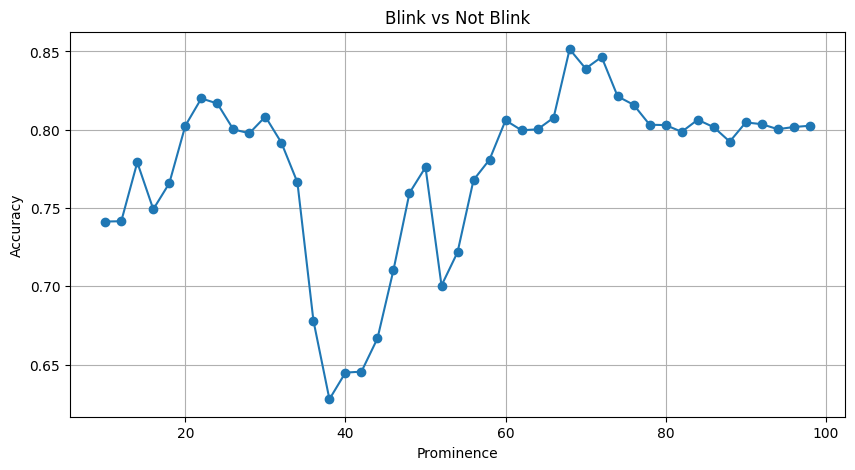

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(blink_results_df["Prominence"], blink_results_df["Accuracy"],
         marker='o', linestyle='-')
plt.xlabel('Prominence')
plt.ylabel('Accuracy')
plt.title('Blink vs Not Blink')
plt.grid(True)
plt.savefig('acc_vs_prominence_blink.png')
plt.show()

score: 78.5%


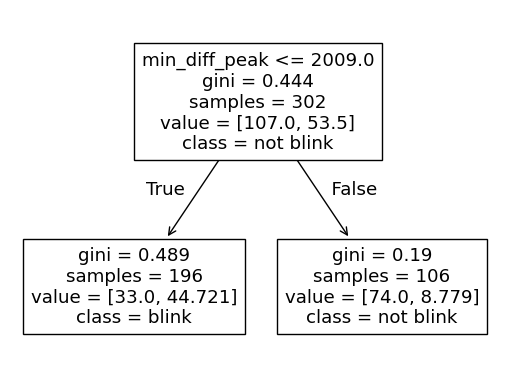

In [15]:
from sklearn.tree import plot_tree

X = clip_feat_df.iloc[:, 5:].to_numpy()
y = (clip_feat_df["label"] == "blink").to_numpy()

model = blink_dt = DecisionTreeClassifier(
    max_depth=1,
    class_weight={True: (len(y) / np.sum(y) - 1) / 2, False: 1})
model.fit(X, y)

print(f"score: {model.score(X, y):.1%}")

plot_tree(model,
          feature_names=clip_feat_df.columns[5:],
          class_names=["not blink", "blink"])
plt.savefig("blink_classifier.png")
plt.show()

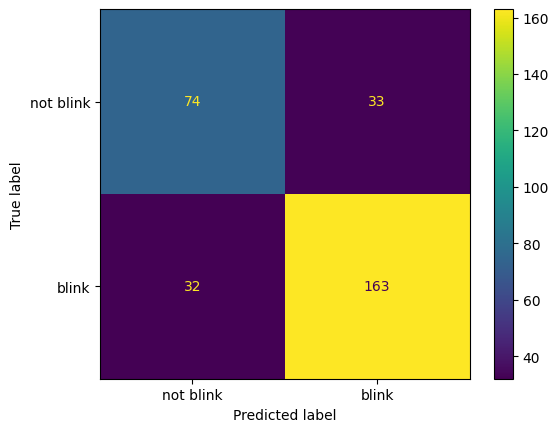

In [16]:
cm = confusion_matrix(y, model.predict(X))
ConfusionMatrixDisplay(cm, display_labels=["not blink", "blink"]).plot()
plt.show()

### Left vs Right

After a "Not Blink" event is detected, the next step is to determine whether it is "left" or "right". The significant difference between the left and right event is the sequence in which high and low peaks occur in a window. If the mean time of the high peaks is less than the mean time of the low peaks, it means that the high peaks generally occur before the low peaks which indicate the eye movement is "Left". Therefore, this classifier is defined as if the average time of high peaks is less than that of the low peaks, then the event is classified as "Left".  If not, the event should be "Right".


accuracy score: 89.7%


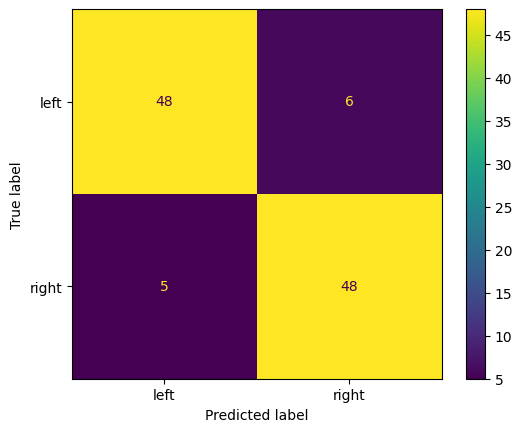

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

clip_lr_df = clip_df[clip_df["label"].isin(["left", "right"])].reset_index()

# the nodes are swapped in some weeks
clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"] = \
    clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"].map(
        {"left": "right", "right": "left"}.get)

amps = clip_lr_df[["amp"]]
label = clip_lr_df["label"].astype("category")

def lr_classify(amp):
    high_peaks, _ = find_peaks(amp, prominence=50)
    low_peaks, _ = find_peaks(-amp, prominence=50)
    if len(high_peaks) and len(low_peaks):
        return ["left", "right"][int(np.mean(high_peaks) < np.mean(low_peaks))]
    else:
        return "left"

prediction = amps.map(lr_classify).astype("category")

print(f"accuracy score: {accuracy_score(label, prediction):.1%}")
cm = confusion_matrix(label, prediction, labels=["left", "right"])
ConfusionMatrixDisplay(cm, display_labels=["left", "right"]).plot()
plt.show()

In [18]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score


clip_lr_df = clip_df[clip_df["label"].isin(["left", "right"])].reset_index()


clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"] = \
    clip_lr_df.loc[clip_lr_df["week"].isin([6]), "label"].map(
        {"left": "right", "right": "left"}.get)

def lr_classify(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    if len(high_peaks) > 0 and len(low_peaks) > 0:
        return "right" if np.mean(high_peaks) < np.mean(low_peaks) else "left"
    return "left"

prominence_values = np.arange(10, 100, 2)
results = []

for prominence in prominence_values:
    prediction = clip_lr_df["amp"].apply(lr_classify, prominence=prominence).astype("category")
    accuracy = balanced_accuracy_score(clip_lr_df["label"], prediction)
    results.append((prominence, accuracy))

lateral_results_df = pd.DataFrame(results, columns=["Prominence", "Accuracy"])
lateral_results_df

,Prominence,Accuracy
0,10,0.504542
1,12,0.420510
2,14,0.495108
3,16,0.533019
4,18,0.589273
5,20,0.645178
6,22,0.747379
7,24,0.803809
8,26,0.804158
9,28,0.813592


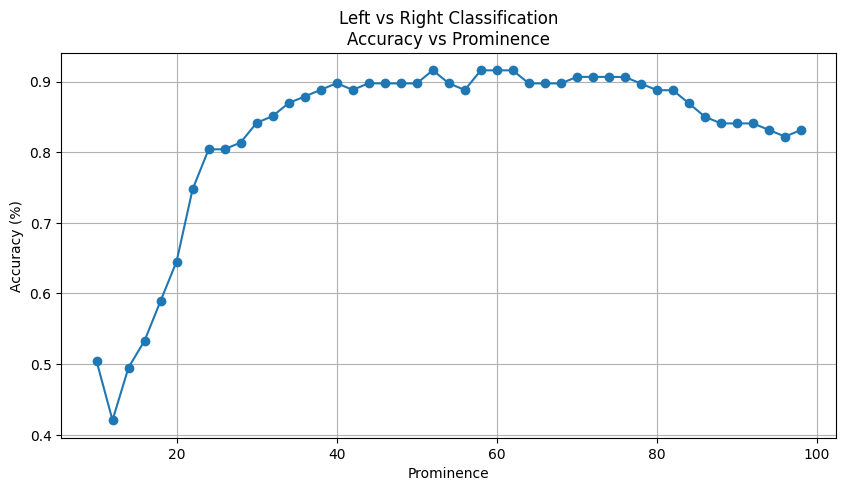

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(lateral_results_df["Prominence"], lateral_results_df["Accuracy"],
         marker='o', linestyle='-')
plt.xlabel('Prominence')
plt.ylabel('Accuracy (%)')
plt.title('Left vs Right Classification\nAccuracy vs Prominence')
plt.grid(True)
plt.show()

### Single vs Double

Now this event has been classified as "Blink'', "Left", or "Right" by the previous steps. In this step, the event will be determined whether it is a single event or a double event. To begin with, the window will be smoothed and find more significant peaks. For the smoothed data, it's necessary to find the number of high peaks by the SciPy library again, because the number of high peaks of smoothed data can indicate the number of times the event occurred. Therefore, the "Is Double vs Not Double" classifier is defined as If there are two or more high peaks, the event is classified as a "Double" event. Otherwise, it's considered a "Single" event.


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

clip_dbl_df = clip_df[(clip_df["week"].isin([9, 10, 11]))
    & (~clip_df["label"].isin(["test", "no"]))].reset_index()

def dbl_features(amp):
    high_peaks, _ = find_peaks(amp, prominence=50)
    low_peaks, _ = find_peaks(-amp, prominence=50)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    return {
        "len": len(amp),
        "n_peak": len(peaks)
    }

clip_dbl_feat = pd.DataFrame([*clip_dbl_df["amp"].progress_apply(dbl_features)])
clip_dbl_feat_df = clip_dbl_df.drop(columns=["time", "amp"]).join(clip_dbl_feat)
clip_dbl_feat_df

  0%|          | 0/250 [00:00<?, ?it/s]

,index,week,path,label,double,len,n_peak
0,0,10,data/week10/1005BLINKS1.csv,blink,False,13633,1
1,1,10,data/week10/1005BLINKS1.csv,blink,False,18306,2
2,2,10,data/week10/1005BLINKS1.csv,blink,False,19781,1
3,3,10,data/week10/1005BLINKS1.csv,blink,False,20012,1
4,4,10,data/week10/1005BLINKS1.csv,blink,False,20089,2
...,...,...,...,...,...,...,...
245,297,9,data/week9/double/right/2204doubleright.csv,right,True,39606,7
246,298,9,data/week9/double/right/2204doubleright.csv,right,True,38246,4
247,299,9,data/week9/double/right/2204doubleright.csv,right,True,38340,7
248,300,9,data/week9/double/right/2204doubleright1.csv,right,True,39440,8


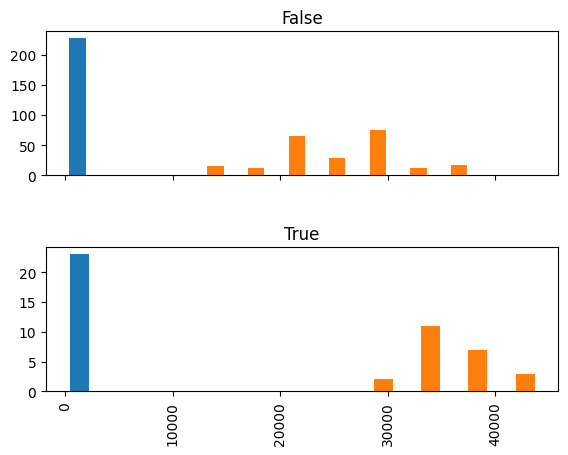

In [21]:
clip_dbl_feat_df[["double", "len"]].hist(by="double", sharex=True, layout=[2, 1])
plt.show()

In [22]:
X = clip_dbl_feat_df.iloc[:, 5:].to_numpy()
y = clip_dbl_feat_df["double"].to_numpy()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    model = DecisionTreeClassifier(max_depth=1, class_weight="balanced")
    model.fit(X_train, y_train)
    scores.append(accuracy_score(y_test, model.predict(X_test)))

print(f"k-fold score: {np.mean(scores):.1%}")

k-fold score: 92.8%


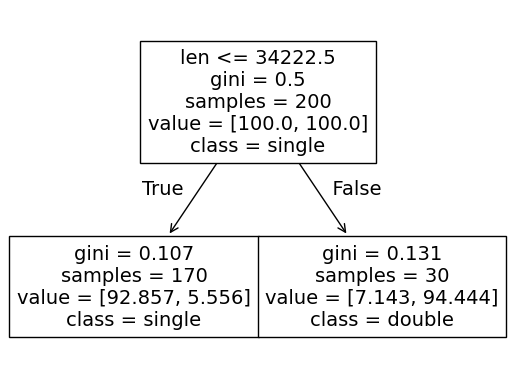

In [23]:
plot_tree(model,
          feature_names=clip_dbl_feat_df.columns[5:],
          class_names=["single", "double"])
plt.show()

In [24]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

def dbl_features(amp, prominence):
    high_peaks, _ = find_peaks(amp, prominence=prominence)
    low_peaks, _ = find_peaks(-amp, prominence=prominence)
    peaks = np.sort(np.concatenate([high_peaks, low_peaks]))
    return {
        "len": len(amp),
        "n_peak": len(peaks)
    }

clip_good_df = clip_df[(~clip_df["label"].isin(["test", "no"]))].reset_index()

prominence_values = np.arange(10, 100, 2)
results = []

for prominence in tqdm(prominence_values):

    clip_dbl_feat = pd.DataFrame([*clip_dbl_df["amp"].apply(dbl_features, prominence=prominence)])
    clip_dbl_feat_df = clip_dbl_df.drop(columns=["time", "amp"]).join(clip_dbl_feat)

    X = clip_dbl_feat_df.iloc[:, 5:].to_numpy()
    y = clip_dbl_feat_df["double"].to_numpy()

    scores = []
    for _ in range(20):
        kf = StratifiedKFold(n_splits=5, shuffle=True)
        for train_index, test_index in kf.split(X, y):
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
    
            model = DecisionTreeClassifier(max_depth=1, class_weight="balanced")
            model.fit(X_train, y_train)
            scores.append(balanced_accuracy_score(y_test, model.predict(X_test)))

    mean_score = np.mean(scores)
    results.append((prominence, mean_score))

double_results_df = pd.DataFrame(results, columns=["Prominence", "Accuracy"])
double_results_df

  0%|          | 0/45 [00:00<?, ?it/s]

,Prominence,Accuracy
0,10,0.860650
1,12,0.871583
2,14,0.859024
3,16,0.880954
4,18,0.890190
5,20,0.888781
6,22,0.889649
7,24,0.891064
8,26,0.898229
9,28,0.893697


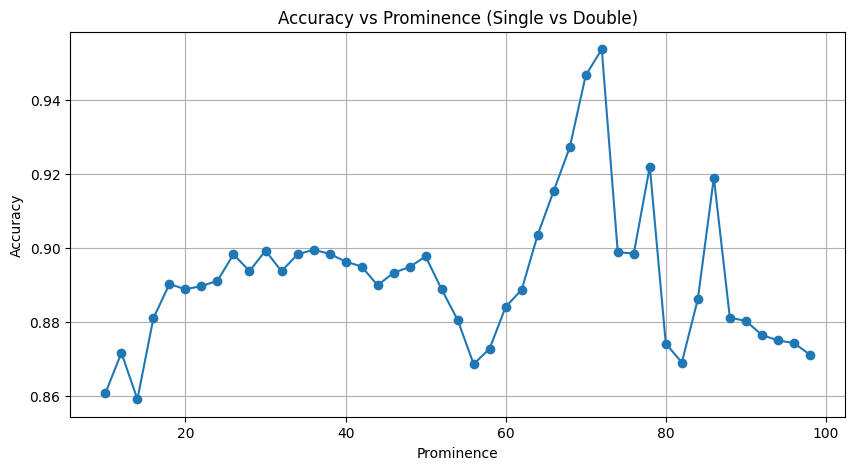

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(double_results_df["Prominence"], double_results_df["Accuracy"],\
         marker='o', linestyle='-')
plt.xlabel('Prominence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prominence (Single vs Double)')
plt.grid(True)
plt.show()

### Combined Results

Grid search was used for hyperparameter estimation. By testing the performance of the model built with a wide range of parameter values and plotting the metrics against the parameter values, the optimal values were determined. This was run multiple times with different combinations of values to increase confidence in the results and reduce error. 

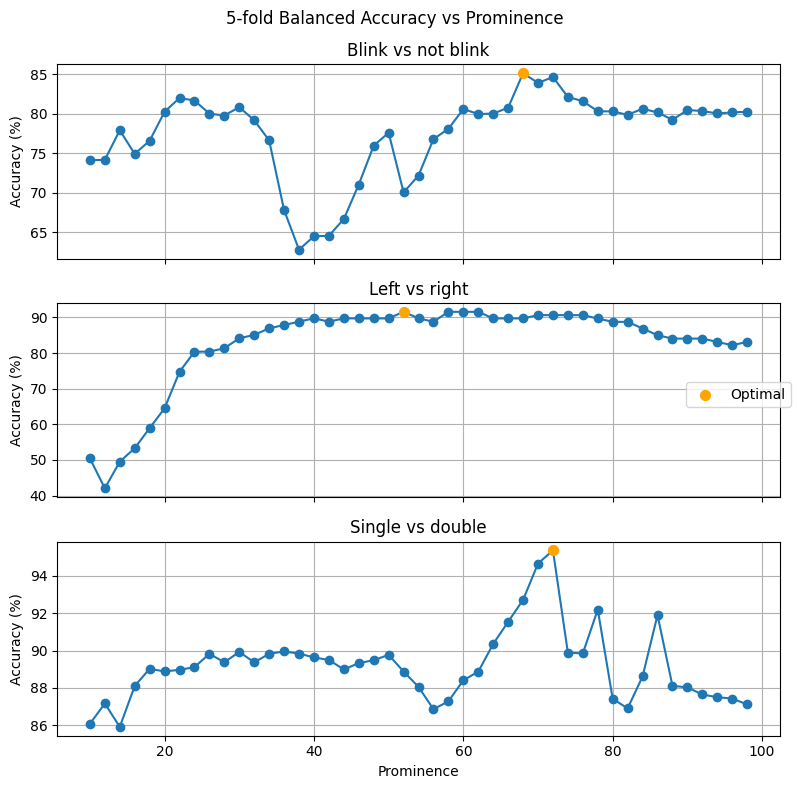

In [26]:
from itertools import zip_longest

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
for ax, results in zip_longest(
        axes.flatten(),
        (("Blink vs not blink", blink_results_df),
         ("Left vs right", lateral_results_df),
         ("Single vs double", double_results_df))):
    if results is None:
        ax.remove()
        continue 
    title, result_df = results
    optimal = result_df[result_df["Accuracy"] == result_df["Accuracy"].max()]
    ax.plot(result_df["Prominence"], result_df["Accuracy"] * 100, marker="o")
    handle = ax.scatter(optimal["Prominence"], optimal["Accuracy"] * 100,
                        color="orange", s=50, zorder=10)
    ax.set_ylabel('Accuracy (%)')
    ax.grid()
    ax.set_title(title)
ax.set_xlabel('Prominence')
fig.suptitle('5-fold Balanced Accuracy vs Prominence')
fig.legend((handle,), ('Optimal',), loc='outside right center')
fig.tight_layout()
fig.savefig('accuracy_vs_prominence.png')
plt.show()

To finalise our model, we examined the confusion matrix to identify weaknesses in our model. A relatively large number outside the diagonal indicates that our model frequently mistakes one class for another. We were therefore able to further improve our model by putting more weight into the frequently mistaken class.

accuracy score: 67.7%


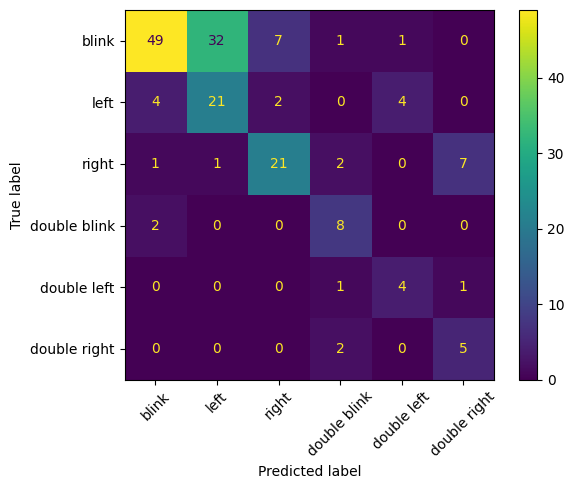

In [27]:
from sklearn.metrics import balanced_accuracy_score

def classify(event):
    high_peaks, _ = find_peaks(event, prominence=70)
    low_peaks, _ = find_peaks(-event, prominence=70)
    if len(high_peaks) == 0 or len(low_peaks) == 0:
        return "blink"
    peaks = np.sort(np.concatenate((high_peaks, low_peaks)))
    min_diff_peak = np.min(np.diff(peaks))
    if min_diff_peak < 2009:
        movement = "blink"
    else:
        if np.mean(high_peaks) > np.mean(low_peaks):
            movement = "left"
        else:
            movement = "right"
    if len(event) > 34222:
        movement = f"double {movement}"
    return movement

clip_comb_df = clip_df[(clip_df["week"].isin([9, 11]))
    & (~clip_df["label"].isin(["test", "no"]))].reset_index()

# the nodes are swapped in some weeks
clip_comb_df.loc[clip_comb_df["week"].isin([6]), "label"] = \
    clip_comb_df.loc[clip_comb_df["week"].isin([6]), "label"].map(
        {"blink": "blink", "left": "right", "right": "left"}.get)

prediction = clip_comb_df["amp"].map(classify)
label = clip_comb_df.apply(
    lambda row: ("double " if row["double"] else "") + row["label"],
    axis=1
)

print(f"accuracy score: {balanced_accuracy_score(label, prediction):.1%}")

cm = confusion_matrix(label, prediction, labels=label.unique())
ConfusionMatrixDisplay(cm, display_labels=label.unique()).plot()
plt.xticks(rotation=45)
plt.savefig("confmat.png", bbox_inches="tight")
plt.show()